# 1. Imports and Configuration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
x_train_preview = pd.read_csv("X_train.csv", nrows=100)
print(x_train_preview.head())


   ID  ID_DAY   RET_216   RET_238    RET_45  RET_295  RET_230   RET_120  \
0   0    3316  0.004024  0.009237  0.004967      NaN  0.01704  0.013885   
1   1    3316  0.004024  0.009237  0.004967      NaN  0.01704  0.013885   
2   2    3316  0.004024  0.009237  0.004967      NaN  0.01704  0.013885   
3   3    3316  0.004024  0.009237  0.004967      NaN  0.01704  0.013885   
4   4    3316  0.004024  0.009237  0.004967      NaN  0.01704  0.013885   

    RET_188   RET_260  ...   RET_122  RET_194    RET_72   RET_293   RET_281  \
0  0.041885  0.015207  ...  0.007596  0.01501  0.014733 -0.000476  0.006539   
1  0.041885  0.015207  ...  0.007596  0.01501  0.014733 -0.000476  0.006539   
2  0.041885  0.015207  ...  0.007596  0.01501  0.014733 -0.000476  0.006539   
3  0.041885  0.015207  ...  0.007596  0.01501  0.014733 -0.000476  0.006539   
4  0.041885  0.015207  ...  0.007596  0.01501  0.014733 -0.000476  0.006539   

    RET_193    RET_95   RET_162   RET_297  ID_TARGET  
0 -0.010233  0.0012

# 2. Load Data

In [5]:
x_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")
x_test = pd.read_csv("X_test.csv")
supplementary = pd.read_csv("supplementary_data.csv")


# 3. Merge Data

In [7]:
train = pd.merge(x_train, y_train, on="ID")
train = pd.merge(train, supplementary, left_on="ID_TARGET", right_on="ID_asset", how="left")


# 4. Create Target Sign

In [9]:
train["SIGN"] = np.sign(train["RET_TARGET"]).astype(int)

# 5. Feature Engineering

In [11]:
ret_cols = [col for col in train.columns if col.startswith("RET_") and col != "RET_TARGET"]
train["RET_MEAN"] = train[ret_cols].mean(axis=1)
train["RET_STD"] = train[ret_cols].std(axis=1)
train["RET_MAX"] = train[ret_cols].max(axis=1)
train["RET_MIN"] = train[ret_cols].min(axis=1)
train["RET_POS"] = (train[ret_cols] > 0).sum(axis=1)
train["RET_NEG"] = (train[ret_cols] < 0).sum(axis=1)

In [12]:
feature_cols = ret_cols + ["RET_MEAN", "RET_STD", "RET_MAX", "RET_MIN", "RET_POS", "RET_NEG"]
X = train[feature_cols]
y = train["SIGN"]
sample_weights = np.abs(train["RET_TARGET"])

# 6. Train/Test Split

In [14]:

X_train, X_val, y_train_split, y_val_split, w_train, w_val = train_test_split(
    X, y, sample_weights, test_size=0.2, random_state=42
)

# 7. Train LightGBM Classifier

In [16]:
clf = lgb.LGBMClassifier(n_estimators=200, max_depth=6)
clf.fit(X_train, y_train_split, sample_weight=w_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26714
[LightGBM] [Info] Number of data points in the train set: 213680, number of used features: 106
[LightGBM] [Info] Start training from score -0.720671
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -0.666361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(max_depth=6, n_estimators=200)

# 8. Predict and Evaluate

In [18]:
def weighted_accuracy_score(y_true, y_pred, weights):
    return np.sum(weights * (y_pred == y_true)) / np.sum(weights)

In [19]:
y_pred = clf.predict(X_val)
weighted_accuracy = weighted_accuracy_score(y_val_split, y_pred, w_val)
print("\n Weighted Accuracy (Val):", weighted_accuracy)


 Weighted Accuracy (Val): 0.691391484191008


# 9. Feature Importance

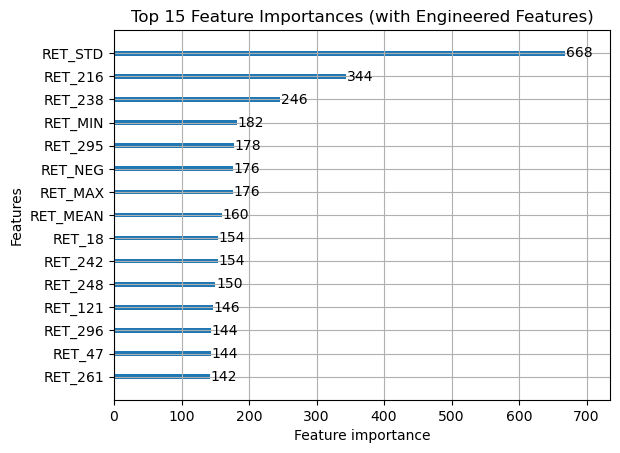

In [21]:
lgb.plot_importance(clf, max_num_features=15)
plt.title("Top 15 Feature Importances (with Engineered Features)")
plt.show()

# 10. Predict on Test and Prepare Submission

In [23]:
x_test["RET_MEAN"] = x_test[ret_cols].mean(axis=1)
x_test["RET_STD"] = x_test[ret_cols].std(axis=1)
x_test["RET_MAX"] = x_test[ret_cols].max(axis=1)
x_test["RET_MIN"] = x_test[ret_cols].min(axis=1)
x_test["RET_POS"] = (x_test[ret_cols] > 0).sum(axis=1)
x_test["RET_NEG"] = (x_test[ret_cols] < 0).sum(axis=1)

In [24]:
test_features = x_test[feature_cols].copy()
test_ids = x_test[["ID"]].copy()
y_test_pred = clf.predict(test_features)

In [29]:
submission = pd.DataFrame({
    "ID": test_ids["ID"],
    "RET_TARGET": y_test_pred  # <- Make sure this matches challenge requirement
})
submission.to_csv("submission.csv", index=False)
